<a href="https://colab.research.google.com/github/sajan-sarker/Deep_Learning_with_PyTorch/blob/main/05_CNN_Fashion_MNIST_PyTorch_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torchinfo
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 20.2 MB/s eta 0:00:00


In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os
import random
import warnings
import torch
import optuna
import torchinfo
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchinfo import summary
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [5]:
# check for device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(("Using :" + torch.cuda.get_device_name(0)) if device.type == 'cuda' else 'Using: CPU')

Using :Tesla T4


In [6]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

*****
### Importing Dataset

Dataset Source: https://www.kaggle.com/datasets/zalando-research/fashionmnist

In [7]:
import kagglehub
#fashion-mnist_train.csv
# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

df = pd.read_csv(path+'/fashion-mnist_train.csv')
df_test = pd.read_csv(path+'/fashion-mnist_test.csv')

print("Train Shape:",df.shape)
print("Test Shape:",df_test.shape)

100%|██████████| 68.8M/68.8M [00:00<00:00, 139MB/s]

Extracting files...


Train Shape: (60000, 785)
Test Shape: (10000, 785)


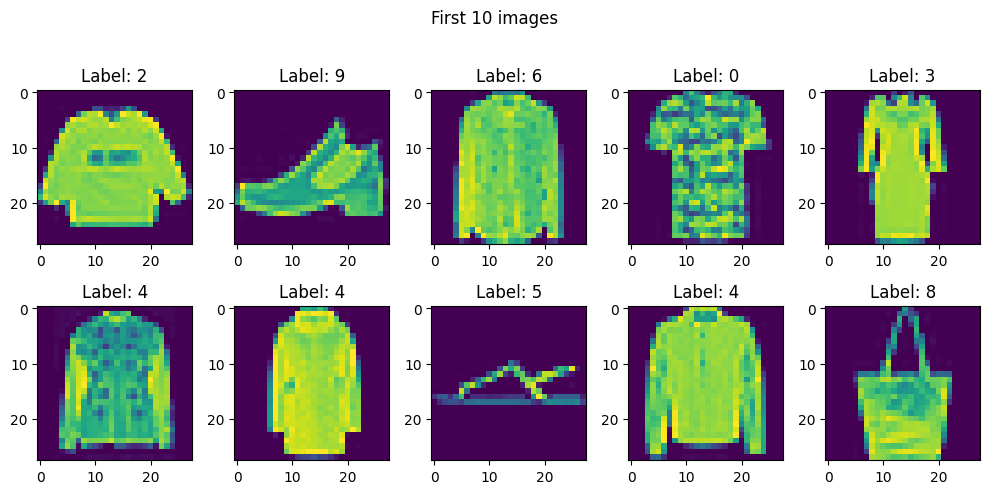

In [8]:
# create a 4x4 grid of images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("First 10 images")

# plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
  img = df.iloc[i, 1:].values.reshape(28, 28) # rehsape 28x28
  ax.imshow(img)
  ax.set_title(f"Label: {df.iloc[i, 0]}")
plt.tight_layout(rect=[0,0,1,0.96]) # adjust layout to fit the title
plt.show()

In [19]:
# train, val, & test split
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

# scaling
X_train = X_train/255.0
X_val = X_val/255.0
X_test = X_test/255.0

*****
### Dataset Class

In [10]:
# Dataset Class
class CNNDataset(Dataset):
  def __init__(self, X, y, transform=None):
    self.X = torch.FloatTensor(X).reshape(-1, 1, 28, 28) # batch size - channel - weight - height
    self.y = torch.LongTensor(y)
    self.transform = transform

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    feature, label = self.X[idx], self.y[idx]
    if self.transform:
      feature = self.transform(feature.squeeze(0).numpy())  # apply transform
    return feature, label

*****
### Network

In [34]:
class CNN(nn.Module):
  def __init__(self, input_channel, output_dim, num_conv_layers, num_filters, kernel_size, num_fc_layers, fc_layer_size, dropout_rate):
    super().__init__()

    # feature extraction layers
    input_channel = input_channel
    layers = [] # dynamic network
    for _ in range(num_conv_layers):
      layers.append(nn.Conv2d(input_channel, num_filters, kernel_size=kernel_size, padding='same'))
      layers.append(nn.ReLU())
      layers.append(nn.BatchNorm2d(num_filters))
      layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
      input_channel = num_filters # update for next layer


    self.features = nn.Sequential(*layers)

    # fc layers
    fc_layers = [nn.Flatten()]  # dynamic network
    input_size = num_filters * (28 // (2 ** num_conv_layers)) ** 2
    for _ in range(num_fc_layers):
      fc_layers.append(nn.Linear(input_size, fc_layer_size))
      fc_layers.append(nn.ReLU())
      fc_layers.append(nn.Dropout(dropout_rate))
      input_size = fc_layer_size

    fc_layers.append(nn.Linear(input_size, output_dim))

    self.classifier = nn.Sequential(*fc_layers)

  def forward(self, X):
    X = self.features(X)
    X = self.classifier(X)
    return X

*****
### Hyperparameter tuning

In [32]:
# define the objective funciton for optuna
def objective(input_channel, output_dim, criterion, train_dataset, val_dataset, trial):
  # hyperparameters to tune
  num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)
  num_filters = trial.suggest_categorical('num_filters', [16, 32, 64, 128])
  kernel_size = trial.suggest_categorical('kernel_size', [3,5])
  num_fc_layers = trial.suggest_int('num_fc_layers', 2, 4)
  fc_layer_size = trial.suggest_categorical('fc_layer_size', [64, 128, 256])
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
  batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
  num_epochs = trial.suggest_int('num_epochs', 20, 50)

  # init model
  model = CNN(input_channel, output_dim, num_conv_layers, num_filters, kernel_size, num_fc_layers, fc_layer_size, dropout_rate).to(device)
  # optimizer
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  # train & val loader object
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

  # training loop
  model.train()
  for epoch in range(num_epochs):
      for X, y in train_loader:
          X, y = X.to(device), y.to(device) # mve to gpu
          # forward pass
          pred = model(X)
          # calculate loss
          loss = criterion(pred, y)
          # backward pass
          optimizer.zero_grad()
          loss.backward()
          # update gradient
          optimizer.step()

  # validation loop
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for X, y in val_loader:
      X, y = X.to(device), y.to(device) # move to gpu

      pred = model(X)
      _, predicted = torch.max(pred, 1)
      total += y.shape[0]
      correct += (predicted == y).sum().item()

  accuracy = correct / total
  return accuracy

In [28]:
# train, val & test dataset
train_dataset = CNNDataset(X_train, y_train)
val_dataset = CNNDataset(X_val, y_val)
test_dataset = CNNDataset(X_test, y_test)

In [36]:
input_channel = 1
output_dim = 10
criterion = nn.CrossEntropyLoss()
n_trials = 20

# init optuna study with minimize validation loss
pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(
    lambda trial: objective(input_channel, output_dim, criterion, train_dataset, val_dataset, trial),
    n_trials = n_trials,
    n_jobs=3
)

[I 2025-03-21 15:15:05,629] A new study created in memory with name: no-name-35a9d9f6-74e0-4b0f-9ebd-122f5195b8b6
[I 2025-03-21 15:17:13,481] Trial 14 finished with value: 0.9184166666666667 and parameters: {'num_conv_layers': 2, 'num_filters': 128, 'kernel_size': 5, 'num_fc_layers': 4, 'fc_layer_size': 256, 'dropout_rate': 0.4247137569705108, 'weight_decay': 1.23456394564125e-05, 'learning_rate': 0.0015378124750358073, 'batch_size': 32, 'num_epochs': 29}. Best is trial 7 with value: 0.9211666666666667.
[I 2025-03-21 15:17:52,382] Trial 13 finished with value: 0.92175 and parameters: {'num_conv_layers': 2, 'num_filters': 128, 'kernel_size': 5, 'num_fc_layers': 4, 'fc_layer_size': 256, 'dropout_rate': 0.4731533749703076, 'weight_decay': 1.3779749235699112e-05, 'learning_rate': 0.0016710496549467119, 'batch_size': 32, 'num_epochs': 28}. Best is trial 13 with value: 0.92175.
[I 2025-03-21 15:20:01,574] Trial 15 finished with value: 0.9179166666666667 and parameters: {'num_conv_layers': 2,

*****
### Final Classifier

In [37]:
print("Best Hyper parameters", study.best_params)
print("Best Accuracy:", study.best_value)

Best Hyper parameters {'num_conv_layers': 1, 'num_filters': 128, 'kernel_size': 3, 'num_fc_layers': 2, 'fc_layer_size': 256, 'dropout_rate': 0.400940563647793, 'weight_decay': 7.366837358061805e-05, 'learning_rate': 0.0026117421017039576, 'batch_size': 32, 'num_epochs': 50}
Best Accuracy: 0.9218333333333333


In [46]:
# init final classifier with best params
best_params = study.best_params
cnn_classifier = CNN(
    input_channel = input_channel,
    output_dim = output_dim,
    num_conv_layers = best_params['num_conv_layers'],
    num_filters = best_params['num_filters'],
    kernel_size = best_params['kernel_size'],
    num_fc_layers = best_params['num_fc_layers'],
    fc_layer_size = best_params['fc_layer_size'],
    dropout_rate = best_params['dropout_rate']
).to(device)

optimizer = optim.SGD(cnn_classifier.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False, pin_memory=True)
num_epochs = best_params['num_epochs']

In [41]:
# training loop
cnn_classifier.train()
for epoch in range(num_epochs):
    total_epoch_loss = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device) # mve to gpu

        # forward pass
        pred = cnn_classifier(X)

        # calculate loss
        loss = criterion(pred, y)

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update gradient
        optimizer.step()

        total_epoch_loss += loss.item()
    avg_loss = total_epoch_loss/len(train_loader)
    print(f"Epoch: {epoch + 1}, Loss: {avg_loss:.4f}")

Epoch: 1, Loss: 0.6262
Epoch: 2, Loss: 0.3932
Epoch: 3, Loss: 0.3351
Epoch: 4, Loss: 0.3020
Epoch: 5, Loss: 0.2732
Epoch: 6, Loss: 0.2525
Epoch: 7, Loss: 0.2348
Epoch: 8, Loss: 0.2205
Epoch: 9, Loss: 0.2051
Epoch: 10, Loss: 0.1921
Epoch: 11, Loss: 0.1808
Epoch: 12, Loss: 0.1721
Epoch: 13, Loss: 0.1601
Epoch: 14, Loss: 0.1516
Epoch: 15, Loss: 0.1422
Epoch: 16, Loss: 0.1334
Epoch: 17, Loss: 0.1264
Epoch: 18, Loss: 0.1194
Epoch: 19, Loss: 0.1123
Epoch: 20, Loss: 0.1057
Epoch: 21, Loss: 0.1006
Epoch: 22, Loss: 0.0928
Epoch: 23, Loss: 0.0888
Epoch: 24, Loss: 0.0852
Epoch: 25, Loss: 0.0781
Epoch: 26, Loss: 0.0707
Epoch: 27, Loss: 0.0702
Epoch: 28, Loss: 0.0637
Epoch: 29, Loss: 0.0623
Epoch: 30, Loss: 0.0572
Epoch: 31, Loss: 0.0541
Epoch: 32, Loss: 0.0521
Epoch: 33, Loss: 0.0486
Epoch: 34, Loss: 0.0468
Epoch: 35, Loss: 0.0435
Epoch: 36, Loss: 0.0430
Epoch: 37, Loss: 0.0384
Epoch: 38, Loss: 0.0372
Epoch: 39, Loss: 0.0350
Epoch: 40, Loss: 0.0344
Epoch: 41, Loss: 0.0318
Epoch: 42, Loss: 0.0323
E

In [58]:
cnn_classifier.eval()

CNN(
  (features): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=25088, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.400940563647793, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.400940563647793, inplace=False)
    (7): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [64]:
def check_acc(model, data):
  # evaluate on data
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for X, y in data:
      X, y = X.to(device), y.to(device) # move to gpu

      pred = model(X)
      _, predicted = torch.max(pred, 1)
      total += y.size(0)
      correct += (predicted == y).sum().item()
  return (correct/total) * 100

print(f"Training Accuracy: {check_acc(cnn_classifier, train_loader):.2f}%")
print(f"Validation Accuracy: {check_acc(cnn_classifier, val_loader):.2f}%")
print(f"Test Accuracy: {check_acc(cnn_classifier, test_loader):.2f}%")

Training Accuracy: 96.73%
Validation Accuracy: 91.85%
Test Accuracy: 92.36%
